This code is copied

In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm


In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('asl_dataset')):
    subfolder_path = os.path.join('asl_dataset', subfolder)
    if not os.path.isdir(subfolder_path) or subfolder=='asl_dataset':
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 36/36 [00:00<00:00, 516.11it/s]


image label
0     asl_dataset\0\hand1_0_bot_seg_1_cropped.jpeg     0
1     asl_dataset\0\hand1_0_bot_seg_2_cropped.jpeg     0
2     asl_dataset\0\hand1_0_bot_seg_3_cropped.jpeg     0
3     asl_dataset\0\hand1_0_bot_seg_4_cropped.jpeg     0
4     asl_dataset\0\hand1_0_bot_seg_5_cropped.jpeg     0
...                                            ...   ...
2510  asl_dataset\z\hand5_z_dif_seg_1_cropped.jpeg     z
2511  asl_dataset\z\hand5_z_dif_seg_2_cropped.jpeg     z
2512  asl_dataset\z\hand5_z_dif_seg_3_cropped.jpeg     z
2513  asl_dataset\z\hand5_z_dif_seg_4_cropped.jpeg     z
2514  asl_dataset\z\hand5_z_dif_seg_5_cropped.jpeg     z

[2515 rows x 2 columns]

In [4]:
df["label"].value_counts()

label
0    70
q    70
k    70
l    70
m    70
n    70
o    70
p    70
r    70
1    70
s    70
u    70
v    70
w    70
x    70
y    70
j    70
i    70
h    70
g    70
2    70
3    70
4    70
5    70
6    70
7    70
8    70
9    70
a    70
b    70
c    70
d    70
e    70
f    70
z    70
t    65
Name: count, dtype: int64

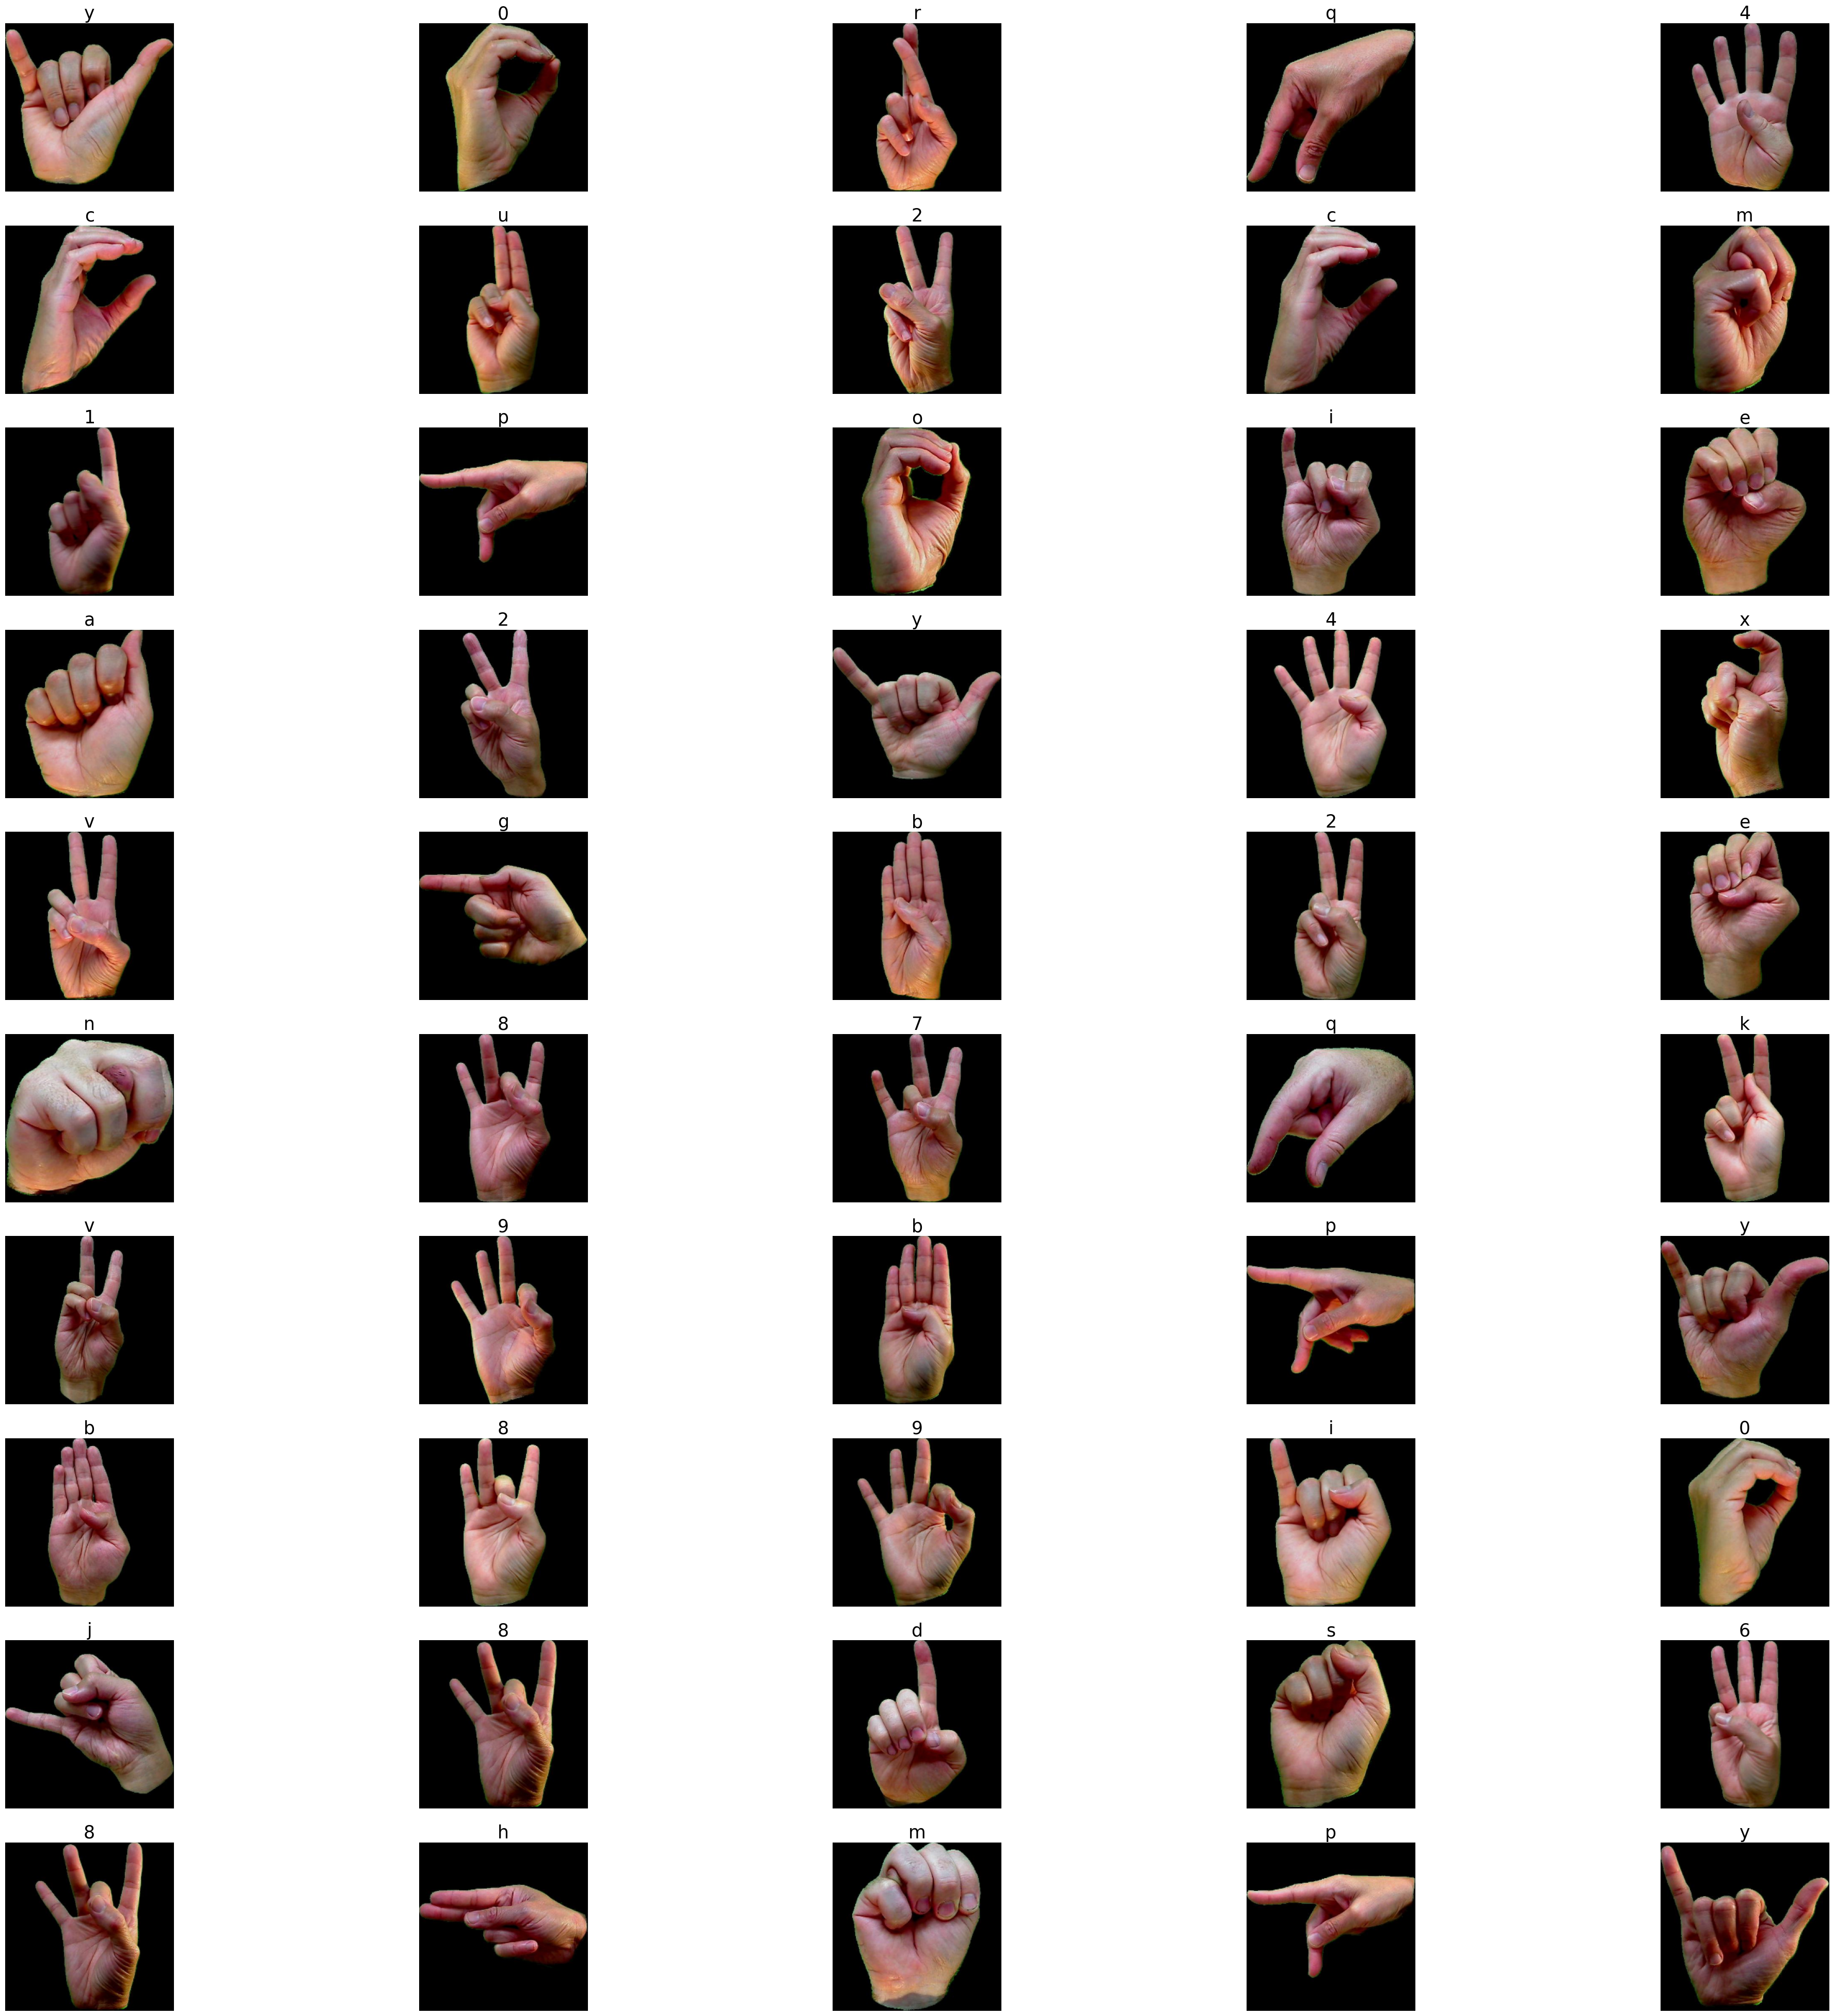

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [6]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [7]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 1760 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.


In [8]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(36, activation=tf.nn.softmax))
model.build(input_shape=(None,224,224,3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,146,724 (80.67 MB)

 Trainable params: 6,432,036 (24.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
checkpoint_cb =ModelCheckpoint("ASL_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

C:\Users\manub\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1975 - loss: 3.5995 - val_accuracy: 0.7029 - val_loss: 1.1184
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6452 - loss: 1.2284 - val_accuracy: 0.9098 - val_loss: 0.4631
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7924 - loss: 0.6831 - val_accuracy: 0.9284 - val_loss: 0.3125
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8559 - loss: 0.4853 - val_accuracy: 0.9231 - val_loss: 0.2980
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8699 - loss: 0.4228 - val_accuracy: 0.9443 - val_loss: 0.1983
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9242 - loss: 0.2785 - val_accuracy: 0.9390 - val_loss: 0.1821
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9133 - loss: 0.2776 - val_accuracy: 0.9469 - val_loss: 0.1490
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9235 - loss: 0.2588 - val_accuracy: 0.9576 - val_loss:

In [11]:
hist=pd.DataFrame(hist.history)
hist

accuracy      loss  val_accuracy  val_loss
0   0.335227  2.613151      0.702918  1.118367
1   0.689773  1.063706      0.909814  0.463142
2   0.806250  0.657412      0.928382  0.312542
3   0.859659  0.483703      0.923077  0.297981
4   0.884091  0.388079      0.944297  0.198279
5   0.917045  0.291760      0.938992  0.182134
6   0.918750  0.258687      0.946950  0.149028
7   0.926705  0.244041      0.957560  0.135430
8   0.942614  0.194259      0.957560  0.126450
9   0.937500  0.198524      0.949602  0.141061
10  0.952273  0.155901      0.949602  0.130420
11  0.948864  0.164014      0.954907  0.112633
12  0.959091  0.138775      0.962865  0.101781
13  0.964773  0.124377      0.965517  0.091669
14  0.957955  0.136983      0.965517  0.097514
15  0.965909  0.111580      0.952255  0.100482
16  0.967045  0.100917      0.965517  0.083707
17  0.969886  0.098284      0.970822  0.090891
18  0.976136  0.088459      0.965517  0.091177
19  0.965341  0.108223      0.976127  0.075622

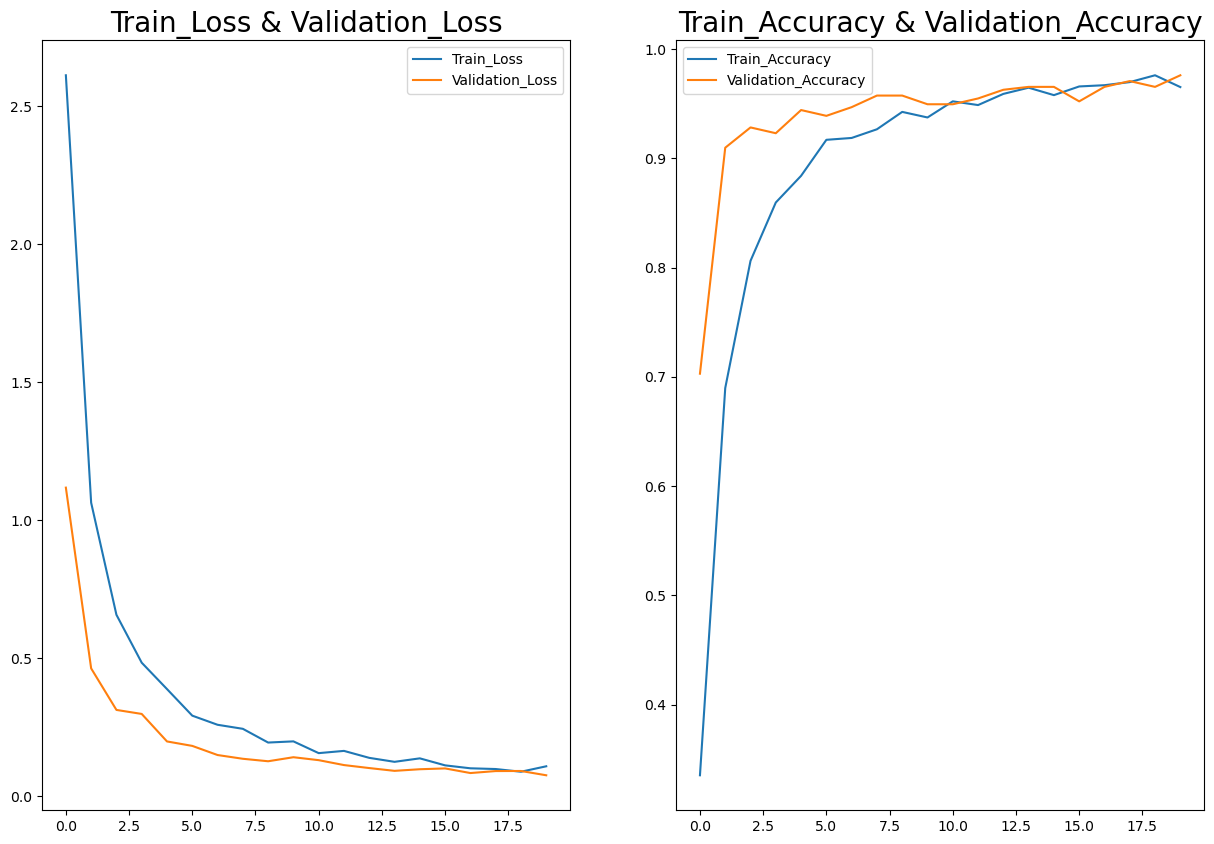

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [13]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

C:\Users\manub\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 753ms/step - accuracy: 0.9662 - loss: 0.0878
Test Loss = 0.07476300746202469
Test Accuracy = 0.9708994626998901


In [14]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/step


Actual  Prediction
0        17          17
1        29          29
2         0           0
3         6           6
4        11          11
..      ...         ...
373      30          30
374      35          35
375      10          10
376      20          20
377       9           9

[378 rows x 2 columns]

In [15]:
model.save("asl_model.h5")
print("Model Saved.")

Model Saved.
